# 4.6 IIR filters and difference equations

## 4.6.1 Implementing IIR filters with data from a file

In the previous chapters we learned how to create a digital filter  
by averaging or by modelling a continuous time system, $H(s)$, as a discrete time system, $H(z)$  
  
In any case, for this chapter, the starting point is the transfer function $H(z)$  
  
  
Consider the transfer functions have determined so far:

* A fourth order FIR filter $$H(z)=\frac{0.2z^4+0.2z^3+0.2z^2+0.2z+0.2}{z^4}$$  
* The forward Euler aproximation to $\frac{10}{s+10}$ at $T=0.05s$ $$H(z)=\frac{0.5}{z-0.5}$$  
* The backward Euler aproximation to $\frac{10}{s+10}$ at $T=0.05s$ $$H(z)=\frac{0.33z}{z-0.67}$$  
* The bilinear aproximation to $\frac{10}{s+10}$ at $T=0.05s$ $$H(z)=\frac{0.2z+0.2}{z-0.6}$$  
* The zero order hold aproximation to $\frac{10}{s+10}$ at $T=0.05s$ $$H(z)=\frac{0.39}{z-0.61}$$  
  
Given the transfer function, we can implement the filter with Python Scipy by creating a dlti object  

The two code cells below perform such a task  
The first cell creates a noisy signal  
Of course, you could use a file you created in lab to generate this signal  
  
The second cell creates the dlti object and then produces the output signal  
We have actually already performed this exact task in the chapter on FIR filters  

For this example we will test the bilinear filter

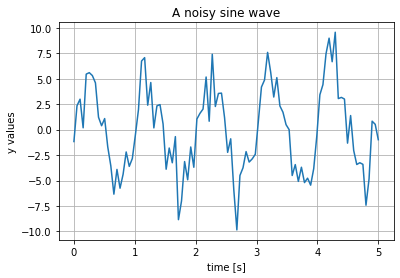

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# create a sine wave signal sampled at 20 samples/sec
t = np.linspace(0, 5, 100)

# 1 Hz sine wave with amplitude of 5
A = -5j
s = 1j*2*np.pi*1
x_clean_t = (A/2)*np.exp(s*t)+(np.conjugate(A)/2)*np.exp(np.conjugate(s)*t)

# create noise 
x_noise_t = np.random.normal(0, 2, len(x_clean_t))

# create a noisy input signal 
x_t = x_clean_t.real + x_noise_t

plt.plot(t, x_t)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('A noisy sine wave')
plt.grid()

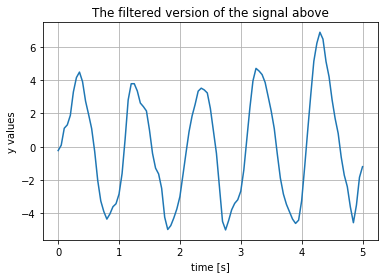

In [2]:
import scipy.signal as sig

num = [10]
den = [1, 10]
H_s = sig.lti(num, den)

dt = 0.05
H_z = H_s.to_discrete(dt=dt, method='bilinear')

t_out, y_t = H_z.output(x_t, t=t)

plt.plot(t_out, y_t)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('The filtered version of the signal above')
plt.grid()

## 4.6.2 Creating digital filters with Scipy

Python's Scipy library has several methods to create a continuous time or discrete time filters  
the chapter on FIR filter had several links to the FIR methods in Scipy  
The methods return the starting point of a filter; the transfer function  

For the next example, let's create a $3^{rd}$ order Butterworth filter  
[Butterworth filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter)  
  
We will create a $3^{rd}$ order Butterworth filter with the same  
sampling rate (20 samples/sec) and cut-off frequency (10[rad/s])  
as our previous first order example  
  
How the Scipy discrete time methods define a cut-off frequency is rather difficult to understand  
The method wants a value between 0 and 1, where 1 represents the Nyquist-Shannon sampling limit  
For a system sampled at 20 samples/sec, the Nyquist-Shannon limit is 10Hz (half the sampling rate)  
Converting to radians/second, $\omega=2\pi f=62.8[rad/s]$  
So a cut-off frequency of 10[rad/s] is represented by $\frac{10}{62.8}=0.159$  

The code cell below creates the filter  

In [3]:
num, den = sig.butter(3, 0.159)
print('num =', num)
print('den =', den)

num = [0.01001722 0.03005167 0.03005167 0.01001722]
den = [ 1.         -2.00992459  1.45421983 -0.36415745]


Just so we can be sure the filter is what we expect  
let's create a dlti object and plot the Bode plot  
  
The code cell below creates the Bode plot  

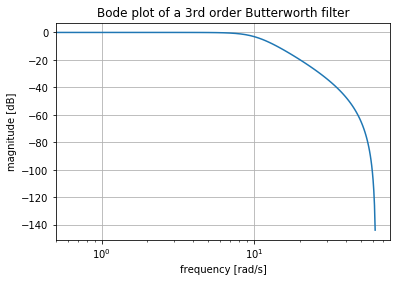

In [4]:
H_z = sig.dlti(num, den, dt=0.05)
w, mag, phase = H_z.bode()

plt.plot(w, mag)
plt.xscale('log')
plt.xlabel('frequency [rad/s]')
plt.ylabel('magnitude [dB]')
plt.title('Bode plot of a 3rd order Butterworth filter')
plt.grid()

The third-order Butterworth filter created by Scipy should do a much better job of filtering  
than the first-order system we created, because of the higher order  
  
You should realize that you could use the methods we learned in the previous chapters  
to create the transfer function by hand, that is the technique Scipy uses anyway  
Although their documentation does not say, I believe they are using the bilinear approximation with pre-warping  

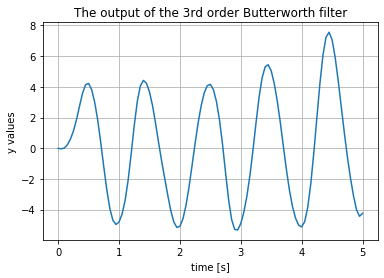

In [5]:
t_out, y_t = H_z.output(x_t, t=t)

plt.plot(t_out, y_t)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('The output of the 3rd order Butterworth filter')
plt.grid()

## 4.6.3 Implementing real-time digital filters

The math Scipy did above is often called digital signal processing, or DSP  
However, if we want to implement filters on real hardware, we need to learn how a DSP processor works  
For our simple filters, we can utilize an Arduino as a DSP processor  
Most traditional Arduino development boards are too slow for any effective DSP processing,  
however, that is changing all the time.  
Today, Arduino development boards are running ARM M4 or even ARM M7  
processors with plenty of speed for many effective DSP applications  
  
A block diagram of the system we want to implement on a DSP processor is shown below  
![image1!](./images_s4/image_4_6_1.png)  
We understand that the zero-order hold of the DAC will have a slight impact on the transfer function  
However, in these filter applications, we typically only concern ourselves with $H(z)$,  
rather than the entire continuous time transfer function H(s)  
  
Inputs can be created by wave generators or sensors and outputs can be viewed on an oscilloscope screen  

## 4.6.4 Writing difference equations

The key to implementing filters on an Arduino requires learning how to write the difference equation for the transfer function  
In the chapter on FIR filters, we showed how to implement the FIR filter in real time  
  
This is the same exact thing, it's not different  
However, it's easier to write difference equations for a FIR filters, because the filter is created from the difference equation    
The difference equation for the FIR filter was the average of the last five input samples  
  
$$Y[k]=0.2X[k]+0.2X[k-1]+0.2X[k-2]+0.2X[k-3]+0.2X[k-4]$$  
We will see the difference equation for IIR filters contains past output values as well as past input samples  
But other than that, the difference equations look the same  
  
To learn how to write difference equations, let's use the first order bilinear approximation we tested above  
Remember, the transfer function describes the output over the input  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.2z+0.2}{z-0.6}$$  
The trick to writing difference equations is to express the transfer function in terms of time delays  
  
You need to find the highest order term of the polynomials in the transfer function  
For our transfer function, it is order 1, or $z$ to the first power  
  
This means we multiply the transfer function by $\frac{z^{-1}}{z^{-1}}$, which doesn't change anything because it is just 1  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.2+0.2z^{-1}}{1-0.6z^{-1}}$$  
Whenever you write the transfer function in this form, the first term of the denominator should always be 1  
  
The next step is to cross multiply with the input and output signals  
You will get the following  
  
$$Y(z)(1-0.6z^{-1})=X(z)(0.2+0.2z^{-1})$$  
Distribute the terms  
  
$$Y(z)-0.6Y(z)z^{-1}=0.2X(z)+0.2X(z)z^{-1}$$  
You can now interpret, $z^{-1}$ as a delay to the previous sample  
Assume that $Y(z)$ represents the current output value,  
and $Y(z)z^{-1}$ represents the previous output value  
  
We will use bracketed $k$ for the current sample and bracketed $k-1$ for the previous sample  
Such that the difference equation becomes  
  
$$Y[k]-0.6Y[k-1]=0.2X[k]+0.2X[k-1]$$  
Finally, solve for the current output, $Y[k]$  
That is the output of the filter that is sent to the DAC  
  
$$Y[k]=0.6Y[k-1]+0.2X[k]+0.2X[k-1]$$  
In the block diagram of the sampled system above, $H(z)$ is implemented with this difference equation  
  
You can recognize IIR filters versus FIR filters,  
because IIR filters have Y (output) and X (input) values on the right hand side of the difference equation  
FIR filters only have X (input) values on the right hand side of the difference equation  

## 4.6.5 Testing the IIR digital filter in real-time 

The code below is written in a form so you can see how to implement the filter  
on an Arduino development board, in real time  
The comments in the code are intended as part of the reading  
  
We showed the coefficients above with only 2 digits of precision, so it's easier to read  
You should use the coefficients reported by the transfer function with all digits of precision  

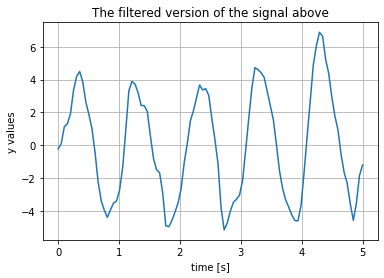

In [6]:
analogRead = x_t

# create a list to remember the output values
analogWrite = []

# a real time filter does not store an array of numbers
# it only needs to store the previous values x[k-1] and y[k-1]
# we will use the variable names x_k1 and y_k1,
# but the variables must be initialized before we start the loop
x_k1 = 0
y_k1 = 0

# in Arduino the for loop below would be the statement
# void loop() {
# in Arduino the loop will run forever, because you don't want your filter to stop
for k in range(len(analogRead)):
    
    x_k = analogRead[k] # read the value from the ADC unit
    
    y_k = 0.6*y_k1 + 0.2*x_k + 0.2*x_k1 # compute y_k from the difference equation
    
    # send the answer to the DAC to produce our countinuous time output
    # the DAC will have a slight impact on the transfer function
    # because of zero-order hold, but we are not accounting for that
    analogWrite.append(y_k) 
    
    # you must remember the current value
    # because it will become the previous value next time around the loop
    # this technique is called pipelining
    # our pipelines are only 1 element deep
    x_k1 = x_k
    y_k1 = y_k    
    
    # in Arduino, you would add a delay to set the sampling rate
    # delayMicroseconds(us) if your filter has a high sampling rate
    # our filter only samples at 20 samples/second, so use the millisecod delay
    # 20 samples/sec gives T = 50 milliseconds
    # delay(50)
    
# That's it, that's the entire code for the filter
plt.plot(t, analogWrite)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('The filtered version of the signal above')
plt.grid()

## 4.6.6 Implementing the Butterworth filter in real time

Just to practice writing difference equations, let repeat the real-time filter for the Butterworth design  
The first thing we need to do is write the difference equation  
The "butter" method returned the transfer function  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.01z^3+0.03z^2+0.03z+0.01}{z^3-2z^2+1.45z-0.36}$$  
The coefficients have been shortened, so it's easier to read  
You really need to use the coefficients in full precision in your code  
  
For DC frequecncies, $z=1$  
If you put $z=1$ into the transfer function, it will give you the DC gain  
(The result below uses the full precision of the coefficients)  
  
$$DC\;gain=\frac{0.01+0.03+0.03+0.01}{1-2+1.45-0.36}=\frac{0.08013778}{0.08013779}\approx 1$$ 
From our Bode plot we are expecting a DC gain of 1  
  
To find the difference equation multiply by $\frac{z^{-3}}{z^{-3}}$  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.01+0.03z^{-1}+0.03z{-2}+0.01z^{-3}}{1-2z^{-1}+1.45z^{-2}-0.36z^{-3}}$$  
cross multiply  
  
$$Y(z)(1-2z^{-1}+1.45z^{-2}-0.36z^{-3})=X(z)(0.01+0.03z^{-1}+0.03z{-2}+0.01z^{-3})$$  
distribute the terms  
  
$$Y(z)-2Y(z)z^{-1}+1.45Y(z)z^{-2}-0.36Y(z)z^{-3}=0.01X(z)+0.03X(z)z^{-1}+0.03X(z)z{-2}+0.01X(z)z^{-3}$$  
interpret $z^{-1}$ as a time delay and solve for the current output  
  
$$Y[k]=2Y[k-1]-1.45Y[k-2]+0.36Y[k-3]+0.01X[k]+0.03X[k-1]+0.03X[k-2]+0.01X[k-3]$$  
The code cell below implements the filter  
some of the comments have been removed to make seeing the code easier  

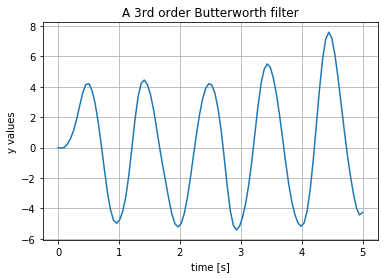

In [7]:
analogRead = x_t
analogWrite = []

x_k1 = 0
x_k2 = 0
x_k3 = 0
y_k1 = 0
y_k2 = 0
y_k3 = 0

for k in range(len(analogRead)):
    x_k = analogRead[k] # read the value from the ADC unit
    
    y_k = 2.00992459*y_k1 # you could write the entire equation on one line
    y_k = y_k - 1.45421983*y_k2 # or you could use +=
    y_k = y_k + 0.36415745*y_k3 # or you can leave it as is
    y_k = y_k + 0.01001722*x_k
    y_k = y_k + 0.03005167*x_k1
    y_k = y_k + 0.03005167*x_k2
    y_k = y_k + 0.01001722*x_k3

    analogWrite.append(y_k) 
    
    # our pipelines are 3 elements deep
    # and you must assign X_k3 and y_k3 first, the order matters
    x_k3 = x_k2
    x_k2 = x_k1
    x_k1 = x_k
    y_k3 = y_k2    
    y_k2 = y_k1    
    y_k1 = y_k    
    
    # delay(50)
    
plt.plot(t, analogWrite)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('A 3rd order Butterworth filter')
plt.grid()

## 4.6.7 Anti-alaising

When a digital sampling system is constructed, it is important to make sure no frequency components of the input,  
greater than half the sampling rate reach the ADC.  The Nyquist-Shannon limit must be obeyed  
  
Most novice engineers ignore the requirement because they see a "beautiful noiseless" wave on the oscilloscope screen  
When Arduino samples a signal, it chops it up into bits.  You may have an 8-bit, 10-bit, or 12-bit ADC  
But, if you display the sampled wave on an oscilloscope screen, you can only resolve about 5-bits with your eye!  

You may see a "beautiful" wave even if bits 6, 7, 8, 9, and 10 are completely noisy  
It's quite possible your application requires a good signal down to 10-bits
  
The proper way to design digital sampling systems,  
is to include an anti-aliasing filter to prevent any signals or noise  
with frequency components greater than half the sampling rate from getting to the ADC  
  
If you are using a 10-bit ADC, then you would need the anti-aliasing filter to suppress  
frequencies at or above half the sampling rate by at least -60 dB, -6 dB/bit  
  
A first-order filter reduces signals above its cut-frequency at -20 dB/decade,  
therefore, a first-order anti-aliasing filter would need to have a  
cut-off frequency 3 decades below half the sampling rate  
In our example, half the sampling rate is 10Hz, or 62.8[rad/s],  
so 3 decades below that is 0.01Hz, but the sine wave that we want to measure is a 1Hz sine wave  
1Hz would not be able to get through that anti-aliasing filter  
  
If we want to allow our 1Hz sine wave to pass, but still provide the proper amount of anti-aliasing  
we would need a $3^{rd}$ order anti-aliasing filter,  
which can reduce signals above the cut-frequency at -60 dB/decade  
The $3^{rd}$ order filter would have a cut-off frequency of 1Hz and will attenuate frequencies at or above 10Hz by at least -60dB    
Anti-aliasing filters must be analog, because they must be in place before the ADC  
  
The diagram below shows the required system with a sampling rate of 20 samples/sec  
![image2!](./images_s4/image_4_6_2.png)  

## 4.6.8 Oversampling

Oversampling simply means sampling at a rate above the Nyquist-Shannon sampling limit  
  
In our system we have been sampling at 20 samples/sec,  
However, if the Arduino can do it, we could sample at 2000 samples/sec,  
way above the Shannon-Nyquist sampling limit for our 1Hz signal of interest!  
  
What this does is change the requirements for the anti-aliasing filter  
Now we need a drop of -60dB at a frequency of 1000Hz, rather than 10Hz  
A simple first order RC filter with a cut-off frequency of 1Hz can do that  
and the 1Hz sine wave we are interested in measuring, can still pass through  
It reduces the amount of circuitry required for anti-aliasing  
Think of oversampling as trading more samples for circuitry  
  
The diagram below shows the simplified system with a sampling rate of 2000 samples/sec  
![image3!](./images_s4/image_4_6_3.png)  